# Updated Performance Measure ($\hat{R}$-HV) for R-EMO Algorithms

## Prerequisite

In [1]:
import numpy as np
import math as ma
import scipy
import random
from pymoo.indicators.hv import HV
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.rnsga3 import RNSGA3
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.rvea import RVEA
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_problem, get_reference_directions
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from scipy.stats import qmc
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from sklearn import preprocessing
from matplotlib.patches import Polygon
import pandas as pd
import xlsxwriter
from pandas import Series, ExcelWriter
from sklearn.metrics.pairwise import euclidean_distances

### Function for Computing Points in circle

In [2]:
def RoI_circle(center, clust, r):
    return np.array([point for point in clust if (center[0] - point[0])**2 + (center[1] - point[1])**2 <= r**2])

### Function for Centroid Computation

In [3]:
def centroid(clust):
    dim = len(clust[0,:])
#     print(dim)
    centr_p = np.zeros([1,dim])
    for i in range(0,dim):
        centr_p[0,i] = np.median(clust[:,i])
#         centr_p[0,i] = np.mean(clust[:,i])
    zp_dist = euclidean_distances(clust, centr_p)
    zp_idx = np.array(zp_dist).argmin()
    centr = clust[zp_idx,:]
    return centr

### Function for Radius Computation

In [4]:
def Radius(clust):
    rad = np.zeros([len(clust),1])
    centr = centroid(clust)
    for i in range(0,len(clust)):      
      rad[i] = ma.dist(centr, clust[i,:])
    r = np.max(rad)
    return r

### Function for Normalizing Data

In [5]:
def Normal(data,UB,LB):
    dim = len(UB)
    normal_data = np.zeros([len(data[:,0]),dim])
    for i in range(0,dim):
        normal_data[:,i] = (data[:,i]-LB[i])/(UB[i]-LB[i])
    return normal_data

### Function for UB and LB Computation

In [6]:
def bounds(data):
    size = len(data[0])
    UB = np.zeros([1,size]); LB = np.zeros([1,size]); 

    for i in range(0,size):
        UB[0,i] = np.max(res.F[:,i])
        LB[0,i] = np.min(res.F[:,i])
        
    return UB, LB

In [7]:
# UB, LB = bounds(ref_directions)

### Existing R-HV Computation

In [8]:
from sklearn.metrics.pairwise import euclidean_distances
def Exist_RHV_points(centr, clust, ref_points):
    ideal_point = [0, 0]
    zp_dist = euclidean_distances(clust, [centr])
    zp_idx = np.array(zp_dist).argmin()
    zp = clust[zp_idx,:]
    ASF = (zp - ideal_point)/(ref_points - ideal_point)
    k = np.array(ASF).argmax()
    zl = ideal_point + ((zp[k] - ideal_point[k])/(ref_points[k] - ideal_point[k]))*(ref_points - ideal_point)
    clust_RHV = clust + (zl-zp)
    return clust_RHV

### Modified R-HV Computation

In [9]:
from sklearn.metrics.pairwise import euclidean_distances
def Mod_RHV_points(ASF_Sol, clust, ref_points):
    
    dim = len(ref_points)
    ## Compute centroid from cluster
    centr = centroid(clust)
    
    ## Compute distance between ASF Solutions and MCDM Centroids
    d_R = ma.dist(ASF_Sol,centr)

    ## New Centroid on Reference line
    vec = ref_points - ASF_Sol
    centra_new = np.zeros([1,dim])
    centra_new = ASF_Sol + d_R*(vec/np.linalg.norm(vec))

    ## Initializing the Shifted MCDM
    clust_RHV = np.zeros([len(clust),dim])

    ## Computing the Shifted MCDM
    clust_RHV = clust + (centra_new - centr)
    return clust_RHV

### Function for Plotting

In [10]:
def plot(PF,MCDM_solns,ref_points,ASF_Sol,a,b):
    import matplotlib
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5, 5))
    plt.rcParams['font.size'] = 12
    MCDM_solns = MCDM_solns[MCDM_solns[:,1]<a]
    MCDM_solns = MCDM_solns[MCDM_solns[:,0]<b]

    plt.scatter(res.F[:, 0],  res.F[:, 1],  s=15, facecolors='k', edgecolors='k')
    plt.scatter(MCDM_solns[:, 0],  MCDM_solns[:, 1],  s=25, facecolors='r', edgecolors='r')

    plt.scatter(ref_points[:, 0], ref_points[:, 1], s=150,  marker='*', facecolors='b', edgecolors='b')

    plt.xlabel('$f_1$',fontsize=14)
    plt.ylabel('$f_2$',fontsize=14)
    plt.legend(["Pareto Front", "MCDM Solns", "Ref Points"], loc ="upper right",fontsize=12)
    plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)

    plt.scatter(ASF_Sol[0, :],  ASF_Sol[1, :],  s=75, facecolors='violet', edgecolors='k')
    
    ideal_point = [min(res.F[:, 0]), min(res.F[:, 1])] 

    plt.plot([ideal_point[0], ref_points[0,0]], [ideal_point[1], ref_points[0,1]], 'bo', linestyle="--")
    plt.plot([ideal_point[0], ref_points[1,0]], [ideal_point[1], ref_points[1,1]], 'bo', linestyle="--")
#     plt.plot([ideal_point[0], ref_points[2,0]], [ideal_point[1], ref_points[2,1]], 'bo', linestyle="--")
    
    plt.plot([ideal_point[0]], [ideal_point[1]], 'mo', linestyle="--")
    plt.text(1.0*ref_points[0,0], 1.05*ref_points[0,1], "$R_1$", fontsize=14)
    plt.text(1.0*ref_points[1,0], 1.1*ref_points[1,1], "$R_2$", fontsize=14)
#     plt.text(1.02*ref_points[2,0], 0.95*ref_points[2,1], "$R_2$", fontsize=14)
    plt.text(1.02*ideal_point[0],  0.5*ideal_point[1], "$O$", fontsize=14)

    plt.xlabel('$f_1$',fontsize=16)
    plt.ylabel('$f_2$',fontsize=16)
    plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
    plt.show()

# PROBLEM DEFINITION STARTS HERE

In [11]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=4,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([1, 2**0.5, 2**0.5, 1]),
                         xu=np.array([3, 3, 3, 3]))

    def _evaluate(self, x, out, *args, **kwargs):
        F = 10; E = 200000; L = 200; S = 10; a = F/S;
        f1 = (L*(2*x[0]+ (2**0.5)*x[1] + x[2]**0.5 + x[3])-1.24019913e+03)/1.57847952e+03
        f2 = ((2*F*L/E)*(1/x[0] + (2**0.5)/x[1] - (2**0.5)/x[2] + 1/x[3]) - 3.26475150e-03)/3.65618970e-02
        out["F"] = [f1, f2]
problem = MyProblem()

In [12]:
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=100)

# create the algorithm object
algorithm = NSGA3(pop_size=101, ref_dirs=ref_dirs)
#algorithm = NSGA2(pop_size=201)
res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               verbose=True,
               seed=1)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      101 |     12 |             - |             -
     2 |      202 |     12 |  0.0577566277 |             f
     3 |      303 |     17 |  0.0218035767 |             f
     4 |      404 |     29 |  0.0285856168 |             f
     5 |      505 |     36 |  0.0186596444 |             f
     6 |      606 |     41 |  0.0083269673 |         ideal
     7 |      707 |     48 |  0.0090180609 |             f
     8 |      808 |     69 |  0.0076614601 |             f
     9 |      909 |     74 |  0.0036303831 |             f
    10 |     1010 |     75 |  0.0041308863 |             f
    11 |     1111 |     76 |  0.0063079877 |         nadir
    12 |     1212 |     86 |  0.0083462734 |         ideal
    13 |     1313 |     84 |  0.0124581021 |         ideal
    14 |     1414 |     88 |  0.0025437416 |             f
    15 |     1515 |     89 |  0.0008300285 |             f
    16 |     1616 |     91 |  0.0020266171 |            

### Computing ASF Solutions

In [13]:
def ASF_solution(ref_point):
    class MyProblem(ElementwiseProblem):

        def __init__(self):
            super().__init__(n_var=4,
                             n_obj=1,
                             n_constr=0,
                             xl=np.array([1, 2**0.5, 2**0.5, 1]),
                             xu=np.array([3, 3, 3, 3]))

        def _evaluate(self, x, out, *args, **kwargs):
            F = 10; E = 200000; L = 200; S = 10; a = F/S;
            f1 = (L*(2*x[0]+ (2**0.5)*x[1] + x[2]**0.5 + x[3])-1.24019913e+03)/1.57847952e+03
            f2 = ((2*F*L/E)*(1/x[0] + (2**0.5)/x[1] - (2**0.5)/x[2] + 1/x[3]) - 3.26475150e-03)/3.65618970e-02
            
            ideal_point = np.array([0,0]);
            
            f_ASF = (np.max((np.array([f1,f2]) - ideal_point)/(ref_point-ideal_point))
                     + 0.0001*np.sum(np.array([f1,f2])/(ref_point-ideal_point)))            

            
            out["F"] = [f_ASF]
            

    problem_ASF = MyProblem()
    
    # OPTIMIZATION HERE
    
    algorithm = GA(pop_size=10,eliminate_duplicates=True)

    res_ASF = minimize(problem_ASF,
               algorithm,
               seed=1, termination=('n_gen', 50),
               verbose=True)
    return res_ASF

In [14]:
ASF_Sol = np.zeros([2,2])
ref_p = np.array([[0.4, 0.9],[0.9, 0.4]])
for i in range(0,2):
    res_ASF = ASF_solution(ref_p[i,:])
    ASF_Sol[i,:] = problem.evaluate(res_ASF.X)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  1.4746483826 |  0.7781826138
     2 |       20 |  1.0153122099 |  0.7293780856
     3 |       30 |  0.7816178481 |  0.7016091445
     4 |       40 |  0.7552041248 |  0.7016091445
     5 |       50 |  0.7225668976 |  0.7016091445
     6 |       60 |  0.6986147387 |  0.6283654036
     7 |       70 |  0.6763800770 |  0.6283654036
     8 |       80 |  0.6416162325 |  0.6215366584
     9 |       90 |  0.6261249573 |  0.6215366584
    10 |      100 |  0.6220731290 |  0.6060338306
    11 |      110 |  0.6192421384 |  0.6059809071
    12 |      120 |  0.6173155558 |  0.6059809071
    13 |      130 |  0.6149224627 |  0.6059657545
    14 |      140 |  0.6129661325 |  0.6059423871
    15 |      150 |  0.6094463154 |  0.6058034684
    16 |      160 |  0.6056987032 |  0.6048667109
    17 |      170 |  0.6054419001 |  0.6047554083
    18 |      180 |  0.6050870382 |  0.6046905831
    19 |      190 |  0.6048025731 |  0.6040323199


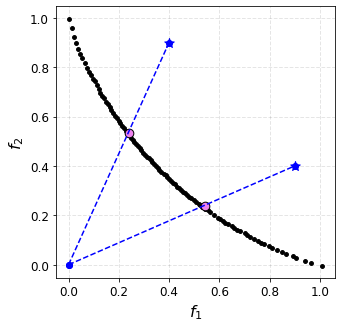

In [15]:
import matplotlib
import matplotlib.pyplot as plt
ref_points = np.array([[0.4, 0.9],[0.9, 0.4]])
plt.figure(figsize=(5, 5))
plt.rcParams['font.size'] = 12
plt.scatter(res.F[:, 0],  res.F[:, 1],  s=15, facecolors='k', edgecolors='k')
plt.scatter(ref_points[:,0], ref_points[:,1], s= 100, marker='*', color='blue', label='Reference Point')
plt.plot([0, ref_points[0,0]], [0, ref_points[0,1]], 'bo', linestyle="--")
plt.plot([0, ref_points[1,0]], [0, ref_points[1,1]], 'bo', linestyle="--")
plt.scatter(ASF_Sol[0, :],  ASF_Sol[1, :],  s=75, facecolors='violet', edgecolors='k')

plt.xlabel('$f_1$',fontsize=16)
plt.ylabel('$f_2$',fontsize=16)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)

## UB and LB Computation 

In [16]:
UB = np.zeros([1,2]); LB = np.zeros([1,2]); 

for i in range(0,2):
    UB[0,i] = np.max(res.F[:,i])
    LB[0,i] = np.min(res.F[:,i])
ideal_point = LB[0,:]; nad_point = UB[0,:];

In [17]:
print(ideal_point)
print(nad_point)
nad_point - ideal_point

[ 0.00195342 -0.0042603 ]
[1.00951832 0.99660888]


array([1.0075649 , 1.00086918])

### R-NSGA-III for MCDM Solutions

In [18]:
# Define reference points
ref_points = np.array([[0.4, 0.9],[0.9, 0.4]])

algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=20,
    mu=0.1)

resMCDM1 = minimize(problem,
               algorithm=algorithm,
               termination=('n_gen', 100),
               extreme_points_as_reference_points=True,
               seed=10,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       42 |      4 |             - |             -
     2 |       84 |      5 |  0.0810005679 |         ideal
     3 |      126 |      7 |  0.0034744552 |         ideal
     4 |      168 |     10 |  0.0261170806 |         ideal
     5 |      210 |     11 |  0.0369724767 |         ideal
     6 |      252 |      7 |  0.1540077281 |         ideal
     7 |      294 |     10 |  0.0221216949 |             f
     8 |      336 |     13 |  0.0178960542 |         ideal
     9 |      378 |     13 |  0.0096738400 |         ideal
    10 |      420 |     13 |  0.0077376176 |             f
    11 |      462 |     14 |  0.0038343626 |         nadir
    12 |      504 |     16 |  0.0035343726 |             f
    13 |      546 |     16 |  0.0021680484 |             f
    14 |      588 |     16 |  0.0087750373 |         ideal
    15 |      630 |     14 |  0.0018687247 |             f
    16 |      672 |     18 |  0.0042989766 |            

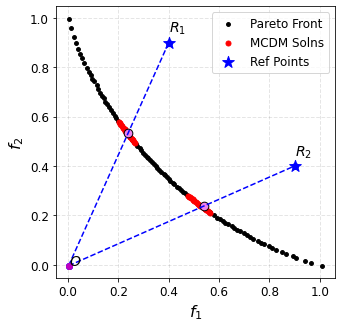

In [19]:
plot(res.F,resMCDM1.F,ref_points,ASF_Sol,0.8,0.8)

### R-HV Computation

In [20]:
N = np.zeros([1,2]); N_RoI = np.zeros([1,2]); r = np.zeros([1,2]); 
H_Vol = np.zeros([1,2]); RH_Vol = np.zeros([1,2]); Mod_RH_Vol = np.zeros([1,2]);

MCDM_solns = resMCDM1.F[resMCDM1.F[:,1]<0.8]
MCDM = MCDM_solns[MCDM_solns[:,0]<0.8]

#2-Clusters
clust1 = MCDM[MCDM[:,1]>0.4]; clust2 = MCDM[MCDM[:,1]<0.4]

#Count of MCDM and MCDM in RoI
N[0,:] = [len(clust1),len(clust2)]; N_RoI[0,:] = [len(clust1),len(clust2)]

#Centroid Computation
centro1 = centroid(clust1); centro2 = centroid(clust2)

#Radius Computation
r1 = Radius(clust1); r2 = Radius(clust2)
r[0,:] = np.array([r1, r2])

#HV Computation 
ind = HV(ref_point=ref_points[0,:])
H_Vol[0,0] =  ind(clust1)

ind = HV(ref_point=ref_points[1,:])
H_Vol[0,1] = ind(clust2)

#R-HV Points Computation
RHV_clust1a = Exist_RHV_points(centro1, clust1, ref_points[0,:])
RHV_clust2a = Exist_RHV_points(centro2, clust2, ref_points[1,:])

RHV = np.concatenate([RHV_clust1a,RHV_clust2a],axis=0)

#R-HV Computation
ind = HV(ref_point=ref_points[0,:])
RH_Vol[0,0] =  ind(RHV_clust1a)

ind = HV(ref_point=ref_points[1,:])
RH_Vol[0,1] = ind(RHV_clust2a)


#R-HV Points Computation
Mod_RHV_clust1a = Mod_RHV_points(ASF_Sol[0,:], clust1, ref_points[0,:])
Mod_RHV_clust2a = Mod_RHV_points(ASF_Sol[1,:], clust2, ref_points[1,:])

Mod_RHV = np.concatenate([Mod_RHV_clust1a,Mod_RHV_clust2a],axis=0)

#R-HV Computation
ind = HV(ref_point=ref_points[0,:])
Mod_RH_Vol[0,0] =  ind(Mod_RHV_clust1a)

ind = HV(ref_point=ref_points[1,:])
Mod_RH_Vol[0,1] = ind(Mod_RHV_clust2a)

print(RH_Vol)
print(Mod_RH_Vol)

[[0.07434709 0.06996665]]
[[0.07001223 0.07107262]]


### Distance from ASF point to Ref point

In [21]:
CR1 = ma.dist(ref_points[0,:],ASF_Sol[0,:])
CR2 = ma.dist(ref_points[1,:],ASF_Sol[1,:])

### New R-HV for R-NSGA-III

In [22]:
res_ASF1 = ASF_solution(centro1)
ASF_sol1 = problem.evaluate(res_ASF1.X)

res_ASF2 = ASF_solution(centro2)
ASF_sol2 = problem.evaluate(res_ASF2.X)

CS1 = ma.dist(centro1,ASF_sol1)
NS3_RHV1 = max(1-CS1/CR1,0)*Mod_RH_Vol[0,0]
CS2 = ma.dist(centro2,ASF_sol2)
NS3_RHV2 = max(1-CS2/CR2,0)*Mod_RH_Vol[0,1]

NS3_RHV = [NS3_RHV1, NS3_RHV2]

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.5490219383 |  1.3047817155
     2 |       20 |  1.7537024041 |  1.2628803144
     3 |       30 |  1.3342055783 |  1.2148001443
     4 |       40 |  1.2606898976 |  1.2148001443
     5 |       50 |  1.2348436796 |  1.1925636360
     6 |       60 |  1.1987117037 |  1.0946485256
     7 |       70 |  1.1419217134 |  1.0709115089
     8 |       80 |  1.0975072340 |  1.0481337585
     9 |       90 |  1.0719375372 |  1.0481337585
    10 |      100 |  1.0656492145 |  1.0481337585
    11 |      110 |  1.0557427847 |  1.0481337585
    12 |      120 |  1.0536890354 |  1.0481337585
    13 |      130 |  1.0513674482 |  1.0480185188
    14 |      140 |  1.0506596267 |  1.0480185188
    15 |      150 |  1.0502387212 |  1.0480185188
    16 |      160 |  1.0493942549 |  1.0480185188
    17 |      170 |  1.0485220629 |  1.0479074683
    18 |      180 |  1.0480282804 |  1.0476225603
    19 |      190 |  1.0479445597 |  1.0476225603


<Figure size 720x864 with 0 Axes>

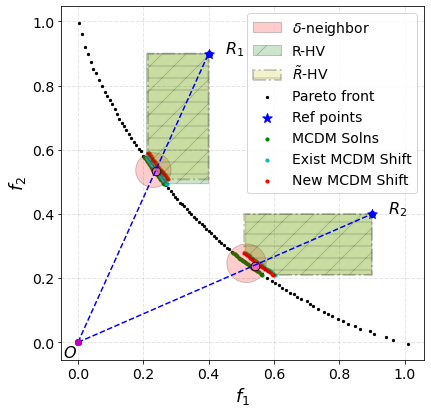

In [23]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 12))
figure, ax = plt.subplots(figsize=(6.5, 6.5))
plt.rcParams['font.size'] = 12
plt.scatter(res.F[:, 0],  res.F[:, 1],  s=5, facecolors='k', edgecolors='k',label="Pareto front")
plt.scatter(ref_points[:,0], ref_points[:,1], s= 100, marker='*', color='blue',label="Ref points")
plt.scatter(MCDM[:,0], MCDM[:,1], s= 10, color='g', edgecolors='g',label="MCDM Solns")
plt.scatter(RHV[:,0], RHV[:,1], s= 10, color='c', edgecolors='c',label="Exist MCDM Shift")
plt.scatter(Mod_RHV[:,0], Mod_RHV[:,1], s= 10, color='r', edgecolors='r',label="New MCDM Shift")
plt.plot([0, ref_points[0,0]], [0, ref_points[0,1]], 'bo', linestyle="--")
plt.plot([0, ref_points[1,0]], [0, ref_points[1,1]], 'bo', linestyle="--")
plt.scatter(ASF_Sol[0, :],  ASF_Sol[1, :],  s=75, facecolors='violet', edgecolors='k')

ax.add_patch(plt.Circle((centro1[0],centro1[1]), r1, facecolor='r', edgecolor='k', alpha=0.2, label="$\delta$-neighbor"))
ax.add_patch(plt.Circle((centro2[0],centro2[1]), r2, facecolor='r', edgecolor='k', alpha=0.2))

HV_cor1=np.array([[np.min(RHV_clust1a[:,0]),np.max(RHV_clust1a[:,1])],[np.max(RHV_clust1a[:,0]),np.min(RHV_clust1a[:,1])],
                    [ref_points[0,0],np.min(RHV_clust1a[:,1])],[ref_points[0,0], ref_points[0,1]], 
                    [np.min(RHV_clust1a[:,0]),ref_points[0,1]]])
p1 = Polygon(HV_cor1, edgecolor='k', facecolor='g', hatch='/', alpha=0.2, label="R-HV")
ax.add_patch(p1)

HV_cor1a=np.array([[np.min(Mod_RHV_clust1a[:,0]),np.max(Mod_RHV_clust1a[:,1])],
                   [np.max(Mod_RHV_clust1a[:,0]),np.min(Mod_RHV_clust1a[:,1])],
                    [ref_points[0,0],np.min(Mod_RHV_clust1a[:,1])],[ref_points[0,0], ref_points[0,1]], 
                    [np.min(Mod_RHV_clust1a[:,0]),ref_points[0,1]]])
p1a = Polygon(HV_cor1a, linestyle='-.', linewidth=2.0, edgecolor='k', facecolor='y', hatch='-', alpha=0.2, label=r"$\tilde{R}$-HV")
ax.add_patch(p1a)

HV_cor2=np.array([[np.min(RHV_clust2a[:,0]),np.max(RHV_clust2a[:,1])],[np.max(RHV_clust2a[:,0]),np.min(RHV_clust2a[:,1])],
                    [ref_points[1,0],np.min(RHV_clust2a[:,1])],[ref_points[1,0], ref_points[1,1]], 
                    [np.min(RHV_clust2a[:,0]),ref_points[1,1]]])
p2 = Polygon(HV_cor2, edgecolor='k', facecolor='g', hatch='/', alpha=0.2)
ax.add_patch(p2)

HV_cor2a=np.array([[np.min(Mod_RHV_clust2a[:,0]),np.max(Mod_RHV_clust2a[:,1])],
                   [np.max(Mod_RHV_clust2a[:,0]),np.min(Mod_RHV_clust2a[:,1])],
                    [ref_points[1,0],np.min(Mod_RHV_clust2a[:,1])],[ref_points[1,0], ref_points[1,1]], 
                    [np.min(Mod_RHV_clust2a[:,0]),ref_points[1,1]]])
p2a = Polygon(HV_cor2a, linestyle='-.', linewidth=2.0, edgecolor='k', facecolor='y', hatch='-', alpha=0.2)
ax.add_patch(p2a)

plt.legend(loc="upper right", fontsize=14)

plt.plot([0.0], [0.0], 'mo', linestyle="--")
plt.text(0.45, 0.9, "$R_1$", fontsize=16)
plt.text(0.95, 0.4, "$R_2$", fontsize=16)
plt.text(-0.045, -0.045, "$O$", fontsize=16)

plt.xlabel('$f_1$',fontsize=18)
plt.ylabel('$f_2$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.savefig("Ex1_NSGA.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [24]:
print(RH_Vol)
print(NS3_RHV)

[[0.07434709 0.06996665]]
[0.06583137765356788, 0.0700361755703964]


In [25]:
print(N)
print(N_RoI)

[[20. 20.]]
[[20. 20.]]


### RVEA for MCDM Solution

In [26]:
reference_directions = resMCDM1.algorithm.survival.ref_dirs
UB1, LB1 = bounds(reference_directions)

reference_directions = reference_directions[reference_directions[:,1]<0.8,:]
reference_directions = reference_directions[reference_directions[:,0]<0.8,:]

ref_directions = Normal(reference_directions ,UB1[0],LB1[0])
len(ref_directions)

40

In [27]:
# ref_directions1

In [28]:
algorithm = RVEA(ref_directions, alpha=2.0, adapt_freq=0.0001)

resMCDM2 = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               seed=1,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |     40 |             - |             -
     2 |       80 |     17 |  0.2933043520 |         ideal
     3 |      120 |     21 |  0.1310549419 |         ideal
     4 |      160 |     23 |  0.1014478601 |         ideal
     5 |      200 |     25 |  0.1098703119 |         nadir
     6 |      240 |     26 |  0.0266278740 |         ideal
     7 |      280 |     27 |  0.1277010859 |         ideal
     8 |      320 |     25 |  0.0324110800 |         ideal
     9 |      360 |     30 |  0.0538018557 |         ideal
    10 |      400 |     34 |  0.0329353139 |         ideal
    11 |      440 |     36 |  0.2672579687 |         nadir
    12 |      480 |     26 |  0.0663216738 |         ideal
    13 |      520 |     27 |  0.0936142701 |         ideal
    14 |      560 |     21 |  0.0616727802 |         ideal
    15 |      600 |     25 |  0.0353582087 |         ideal
    16 |      640 |     25 |  0.0283146398 |         ide

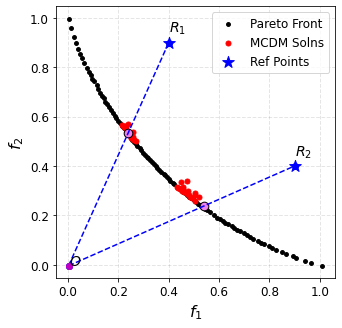

In [29]:
plot(res.F,resMCDM2.F,ref_points,ASF_Sol,0.8,0.8)

### R-HV Computation

In [30]:
N = np.zeros([1,2]); N_RoI = np.zeros([1,2]); 
H_Vol = np.zeros([1,2]); RH_Vol = np.zeros([1,2]); Mod_RH_Vol = np.zeros([1,2]);

MCDM_solns = resMCDM2.F[resMCDM2.F[:,1]<0.8]
MCDM = MCDM_solns[MCDM_solns[:,0]<0.8]

#2-Clusters
clust1 = MCDM[MCDM[:,1]>0.4]; clust2 = MCDM[MCDM[:,1]<0.4]

#Count of MCDM and MCDM in RoI
N[0,:] = [len(clust1),len(clust2)]; 

#Centroid Computation
centro1 = centroid(clust1); centro2 = centroid(clust2)

clust1a = RoI_circle(centro1, clust1, r[0,0])
clust2a = RoI_circle(centro2, clust2, r[0,1])
    
#Count of MCDM in RoI
N_RoI[0,:] = [len(clust1a),len(clust2a)]

#HV Computation 
ind = HV(ref_point=ref_points[0,:])
H_Vol[0,0] =  ind(clust1)

ind = HV(ref_point=ref_points[1,:])
H_Vol[0,1] = ind(clust2)

#R-HV Points Computation
RHV_clust1a = Exist_RHV_points(centro1, clust1a, ref_points[0,:])
RHV_clust2a = Exist_RHV_points(centro2, clust2a, ref_points[1,:])

RHV = np.concatenate([RHV_clust1a,RHV_clust2a],axis=0)

#R-HV Computation
ind = HV(ref_point=ref_points[0,:])
RH_Vol[0,0] =  ind(RHV_clust1a)

ind = HV(ref_point=ref_points[1,:])
RH_Vol[0,1] = ind(RHV_clust2a)

#R-HV Points Computation
Mod_RHV_clust1a = Mod_RHV_points(ASF_Sol[0,:], clust1, ref_points[0,:])
Mod_RHV_clust2a = Mod_RHV_points(ASF_Sol[1,:], clust2, ref_points[1,:])

Mod_RHV = np.concatenate([Mod_RHV_clust1a,Mod_RHV_clust2a],axis=0)

#R-HV Computation
ind = HV(ref_point=ref_points[0,:])
Mod_RH_Vol[0,0] =  ind(Mod_RHV_clust1a)

ind = HV(ref_point=ref_points[1,:])
Mod_RH_Vol[0,1] = ind(Mod_RHV_clust2a)

print(RH_Vol)
print(Mod_RH_Vol)

[[0.07110194 0.03673126]]
[[0.06674044 0.05379967]]


In [31]:
# Mod_RHV

### New R-HV for RVEA

In [32]:
res_ASF1 = ASF_solution(centro1)
ASF_sol1 = problem.evaluate(res_ASF1.X)

res_ASF2 = ASF_solution(centro2)
ASF_sol2 = problem.evaluate(res_ASF2.X)

CS1 = ma.dist(centro1,ASF_sol1)
RV_RHV1 = max(1-CS1/CR1,0)*Mod_RH_Vol[0,0]
CS2 = ma.dist(centro2,ASF_sol2)
RV_RHV2 = max(1-CS2/CR2,0)*Mod_RH_Vol[0,1]

RV_RHV = [RV_RHV1, RV_RHV2]

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.5035808115 |  1.3096131665
     2 |       20 |  1.7233639391 |  1.2389020112
     3 |       30 |  1.3238714832 |  1.1917345232
     4 |       40 |  1.2779446917 |  1.1917345232
     5 |       50 |  1.2372022741 |  1.1860157708
     6 |       60 |  1.1921928185 |  1.0422595620
     7 |       70 |  1.1232138663 |  1.0422595620
     8 |       80 |  1.0668697288 |  1.0399226509
     9 |       90 |  1.0481874529 |  1.0399226509
    10 |      100 |  1.0428106394 |  1.0397997153
    11 |      110 |  1.0411730079 |  1.0397997153
    12 |      120 |  1.0400792855 |  1.0389696283
    13 |      130 |  1.0395433758 |  1.0389122243
    14 |      140 |  1.0391290946 |  1.0373776352
    15 |      150 |  1.0389740616 |  1.0373776352
    16 |      160 |  1.0388300951 |  1.0373776352
    17 |      170 |  1.0386625902 |  1.0373776352
    18 |      180 |  1.0382259775 |  1.0373754390
    19 |      190 |  1.0378247480 |  1.0373754390


In [33]:
print(RH_Vol)
print(RV_RHV)

[[0.07110194 0.03673126]]
[0.06306084710323183, 0.052532923362301406]


In [34]:
print(N)
print(N_RoI)

[[17. 19.]]
[[17. 19.]]


<Figure size 720x864 with 0 Axes>

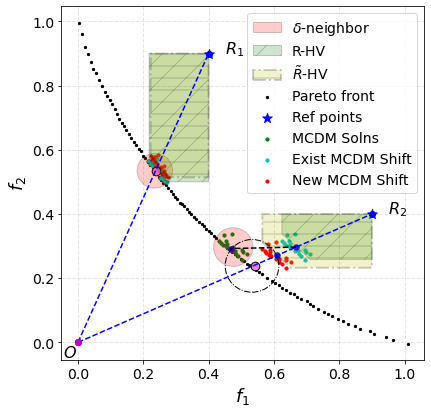

In [35]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 12))
figure, ax = plt.subplots(figsize=(6.5, 6.5))
plt.rcParams['font.size'] = 12
plt.scatter(res.F[:, 0],  res.F[:, 1],  s=5, facecolors='k', edgecolors='k',label="Pareto front")
plt.scatter(ref_points[:,0], ref_points[:,1], s= 100, marker='*', color='blue',label="Ref points")
plt.scatter(MCDM[:,0], MCDM[:,1], s= 10, color='g', edgecolors='g',label="MCDM Solns")
plt.scatter(RHV[:,0], RHV[:,1], s= 10, color='c', edgecolors='c',label="Exist MCDM Shift")
plt.scatter(Mod_RHV[:,0], Mod_RHV[:,1], s= 10, color='r', edgecolors='r',label="New MCDM Shift")
plt.plot([0, ref_points[0,0]], [0, ref_points[0,1]], 'bo', linestyle="--")
plt.plot([0, ref_points[1,0]], [0, ref_points[1,1]], 'bo', linestyle="--")

centr_HV = centroid(RHV_clust2a); centr_Mod_HV = centroid(Mod_RHV_clust2a)
plt.plot([centr_HV[0], ASF_sol2[0]], [centr_HV[1], ASF_sol2[1]], 'k', linestyle="--")
plt.scatter(ASF_Sol[0, :],  ASF_Sol[1, :],  s=75, facecolors='violet', edgecolors='k')
plt.scatter(centr_Mod_HV[0], centr_Mod_HV[1],  s=30, facecolors='b', edgecolors='b')
plt.scatter(ASF_sol2[0], ASF_sol2[1],  s=30, facecolors='b', edgecolors='b')
plt.scatter(centr_HV[0], centr_HV[1],  s=30, facecolors='b', edgecolors='b')



ax.add_patch(plt.Circle((centro1[0],centro1[1]), r1, facecolor='r', edgecolor='k', alpha=0.2, label="$\delta$-neighbor"))
ax.add_patch(plt.Circle((centro2[0],centro2[1]), r2, facecolor='r', edgecolor='k', alpha=0.2))
ax.add_patch(plt.Circle((ASF_Sol[1,0],ASF_Sol[1,1]), ma.dist(centro2,ASF_Sol[1,:]), facecolor='none', 
                        edgecolor='k',linestyle='-.'))

HV_cor1=np.array([[np.min(RHV_clust1a[:,0]),np.max(RHV_clust1a[:,1])],[np.max(RHV_clust1a[:,0]),np.min(RHV_clust1a[:,1])],
                    [ref_points[0,0],np.min(RHV_clust1a[:,1])],[ref_points[0,0], ref_points[0,1]], 
                    [np.min(RHV_clust1a[:,0]),ref_points[0,1]]])
p1 = Polygon(HV_cor1, edgecolor='k', facecolor='g', hatch='/', alpha=0.2, label="R-HV")
ax.add_patch(p1)

HV_cor1a=np.array([[np.min(Mod_RHV_clust1a[:,0]),np.max(Mod_RHV_clust1a[:,1])],
                   [np.max(Mod_RHV_clust1a[:,0]),np.min(Mod_RHV_clust1a[:,1])],
                    [ref_points[0,0],np.min(Mod_RHV_clust1a[:,1])],[ref_points[0,0], ref_points[0,1]], 
                    [np.min(Mod_RHV_clust1a[:,0]),ref_points[0,1]]])
p1a = Polygon(HV_cor1a, linestyle='-.', linewidth=2.0, edgecolor='k', facecolor='y', hatch='-', alpha=0.2, label=r"$\tilde{R}$-HV")
ax.add_patch(p1a)

HV_cor2=np.array([[np.min(RHV_clust2a[:,0]),np.max(RHV_clust2a[:,1])],[np.max(RHV_clust2a[:,0]),np.min(RHV_clust2a[:,1])],
                    [ref_points[1,0],np.min(RHV_clust2a[:,1])],[ref_points[1,0], ref_points[1,1]], 
                    [np.min(RHV_clust2a[:,0]),ref_points[1,1]]])
p2 = Polygon(HV_cor2, edgecolor='k', facecolor='g', hatch='/', alpha=0.2)
ax.add_patch(p2)

HV_cor2a=np.array([[np.min(Mod_RHV_clust2a[:,0]),np.max(Mod_RHV_clust2a[:,1])],
                   [np.max(Mod_RHV_clust2a[:,0]),np.min(Mod_RHV_clust2a[:,1])],
                    [ref_points[1,0],np.min(Mod_RHV_clust2a[:,1])],[ref_points[1,0], ref_points[1,1]], 
                    [np.min(Mod_RHV_clust2a[:,0]),ref_points[1,1]]])
p2a = Polygon(HV_cor2a, linestyle='-.', linewidth=2.0, edgecolor='k', facecolor='y', hatch='-', alpha=0.2)
ax.add_patch(p2a)

plt.legend(loc="upper right", fontsize=14)

plt.plot([0.0], [0.0], 'mo', linestyle="--")
plt.text(0.45, 0.9, "$R_1$", fontsize=16)
plt.text(0.95, 0.4, "$R_2$", fontsize=16)
plt.text(-0.045, -0.045, "$O$", fontsize=16)

plt.xlabel('$f_1$',fontsize=18)
plt.ylabel('$f_2$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.savefig("Ex1_RVEA.pdf", format="pdf", bbox_inches="tight")
# plt.show()

### C-TAEA for MCDM Solutions

In [36]:
# reference_directions_C3a
algorithm = CTAEA(ref_dirs=ref_directions)

# execute the optimization
resMCDM3 = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=True
               )

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |     11 |             - |             -
     2 |       80 |     14 |  0.0080770216 |         ideal
     3 |      120 |     23 |  0.0323110903 |             f
     4 |      160 |     24 |  0.0329408416 |         ideal
     5 |      200 |     24 |  0.0040240792 |             f
     6 |      240 |     26 |  0.0268426831 |         ideal
     7 |      280 |     26 |  0.0079491588 |             f
     8 |      320 |     25 |  0.0317373377 |         ideal
     9 |      360 |     22 |  0.0056590000 |             f
    10 |      400 |     40 |  0.0135073642 |             f
    11 |      440 |     40 |  0.0058345423 |             f
    12 |      480 |     40 |  0.0054369473 |         ideal
    13 |      520 |     40 |  0.0098549931 |         ideal
    14 |      560 |     40 |  0.0598887154 |         ideal
    15 |      600 |     40 |  0.0024867990 |             f
    16 |      640 |     40 |  0.0024682263 |            

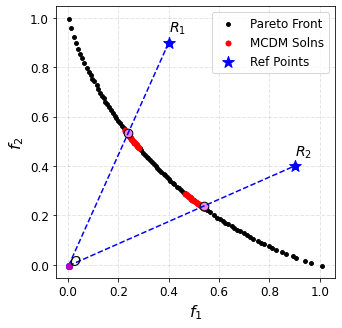

In [37]:
plot(res.F,resMCDM3.F,ref_points,ASF_Sol,0.8,0.8)

### R-HV Computation

In [38]:
N = np.zeros([1,2]); N_RoI = np.zeros([1,2]); 
H_Vol = np.zeros([1,2]); RH_Vol = np.zeros([1,2]); Mod_RH_Vol = np.zeros([1,2]);

MCDM_solns = resMCDM3.F[resMCDM3.F[:,1]<0.8]
MCDM = MCDM_solns[MCDM_solns[:,0]<0.8]

#2-Clusters
clust1 = MCDM[MCDM[:,1]>0.4]; clust2 = MCDM[MCDM[:,1]<0.4]

#Count of MCDM and MCDM in RoI
N[0,:] = [len(clust1),len(clust2)]; 

#Centroid Computation
centro1 = centroid(clust1); centro2 = centroid(clust2)

clust1a = RoI_circle(centro1, clust1, r[0,0])
clust2a = RoI_circle(centro2, clust2, r[0,1])
    
#Count of MCDM in RoI
N_RoI[0,:] = [len(clust1a),len(clust2a)]

#HV Computation 
ind = HV(ref_point=ref_points[0,:])
H_Vol[0,0] =  ind(clust1)

ind = HV(ref_point=ref_points[1,:])
H_Vol[0,1] = ind(clust2)

#R-HV Points Computation
RHV_clust1a = Exist_RHV_points(centro1, clust1a, ref_points[0,:])
RHV_clust2a = Exist_RHV_points(centro2, clust2a, ref_points[1,:])

RHV = np.concatenate([RHV_clust1a,RHV_clust2a],axis=0)

#R-HV Computation
ind = HV(ref_point=ref_points[0,:])
RH_Vol[0,0] =  ind(RHV_clust1a)

ind = HV(ref_point=ref_points[1,:])
RH_Vol[0,1] = ind(RHV_clust2a)

#R-HV Points Computation
Mod_RHV_clust1a = Mod_RHV_points(ASF_Sol[0,:], clust1, ref_points[0,:])
Mod_RHV_clust2a = Mod_RHV_points(ASF_Sol[1,:], clust2, ref_points[1,:])

Mod_RHV = np.concatenate([Mod_RHV_clust1a,Mod_RHV_clust2a],axis=0)

#R-HV Computation
ind = HV(ref_point=ref_points[0,:])
Mod_RH_Vol[0,0] =  ind(Mod_RHV_clust1a)

ind = HV(ref_point=ref_points[1,:])
Mod_RH_Vol[0,1] = ind(Mod_RHV_clust2a)

print(RH_Vol)
print(Mod_RH_Vol)

[[0.06284819 0.05920831]]
[[0.06090676 0.06289186]]


### New R-HV for C-TAEA

In [39]:
res_ASF1 = ASF_solution(centro1)
ASF_sol1 = problem.evaluate(res_ASF1.X)

res_ASF2 = ASF_solution(centro2)
ASF_sol2 = problem.evaluate(res_ASF2.X)

CS1 = ma.dist(centro1,ASF_sol1)
CTA_RHV1 = max(1-CS1/CR1,0)*Mod_RH_Vol[0,0]
CS2 = ma.dist(centro2,ASF_sol2)
CTA_RHV2 = max(1-CS2/CR2,0)*Mod_RH_Vol[0,1]

CTA_RHV = [CTA_RHV1, CTA_RHV2]

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.3605035941 |  1.3736714210
     2 |       20 |  1.6326733686 |  1.1608557672
     3 |       30 |  1.2925665126 |  1.1166585876
     4 |       40 |  1.2366720890 |  1.1166585876
     5 |       50 |  1.1939794394 |  1.1166585876
     6 |       60 |  1.1395260986 |  1.0961504432
     7 |       70 |  1.1147390122 |  1.0726989125
     8 |       80 |  1.0964324878 |  1.0600412911
     9 |       90 |  1.0713491090 |  1.0517439705
    10 |      100 |  1.0630901325 |  1.0395441401
    11 |      110 |  1.0556834447 |  1.0395441401
    12 |      120 |  1.0462014633 |  1.0395441401
    13 |      130 |  1.0411916565 |  1.0376808780
    14 |      140 |  1.0406660528 |  1.0376808780
    15 |      150 |  1.0390546423 |  1.0375967393
    16 |      160 |  1.0382234068 |  1.0364802016
    17 |      170 |  1.0376478057 |  1.0356719482
    18 |      180 |  1.0372859643 |  1.0356719482
    19 |      190 |  1.0367936404 |  1.0353619191


In [40]:
print(RH_Vol)
print(CTA_RHV)

[[0.06284819 0.05920831]]
[0.05785447939676207, 0.0605958136805569]


In [41]:
print(N)
print(N_RoI)

[[20. 20.]]
[[20. 20.]]


<Figure size 720x864 with 0 Axes>

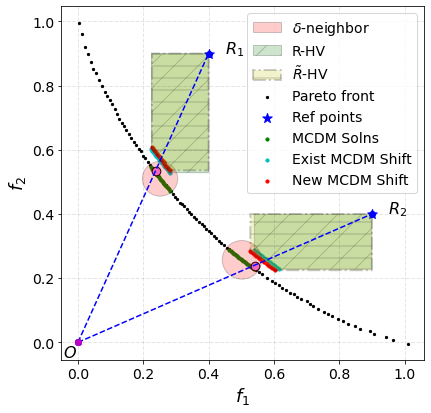

In [42]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 12))
figure, ax = plt.subplots(figsize=(6.5, 6.5))
plt.rcParams['font.size'] = 12
plt.scatter(res.F[:, 0],  res.F[:, 1],  s=5, facecolors='k', edgecolors='k',label="Pareto front")
plt.scatter(ref_points[:,0], ref_points[:,1], s= 100, marker='*', color='blue',label="Ref points")
plt.scatter(MCDM[:,0], MCDM[:,1], s= 10, color='g', edgecolors='g',label="MCDM Solns")
plt.scatter(RHV[:,0], RHV[:,1], s= 10, color='c', edgecolors='c',label="Exist MCDM Shift")
plt.scatter(Mod_RHV[:,0], Mod_RHV[:,1], s= 10, color='r', edgecolors='r',label="New MCDM Shift")
plt.plot([0, ref_points[0,0]], [0, ref_points[0,1]], 'bo', linestyle="--")
plt.plot([0, ref_points[1,0]], [0, ref_points[1,1]], 'bo', linestyle="--")
plt.scatter(ASF_Sol[0, :],  ASF_Sol[1, :],  s=75, facecolors='violet', edgecolors='k')

ax.add_patch(plt.Circle((centro1[0],centro1[1]), r1, facecolor='r', edgecolor='k', alpha=0.2, label="$\delta$-neighbor"))
ax.add_patch(plt.Circle((centro2[0],centro2[1]), r2, facecolor='r', edgecolor='k', alpha=0.2))

HV_cor1=np.array([[np.min(RHV_clust1a[:,0]),np.max(RHV_clust1a[:,1])],[np.max(RHV_clust1a[:,0]),np.min(RHV_clust1a[:,1])],
                    [ref_points[0,0],np.min(RHV_clust1a[:,1])],[ref_points[0,0], ref_points[0,1]], 
                    [np.min(RHV_clust1a[:,0]),ref_points[0,1]]])
p1 = Polygon(HV_cor1, edgecolor='k', facecolor='g', hatch='/', alpha=0.2, label="R-HV")
ax.add_patch(p1)

HV_cor1a=np.array([[np.min(Mod_RHV_clust1a[:,0]),np.max(Mod_RHV_clust1a[:,1])],
                   [np.max(Mod_RHV_clust1a[:,0]),np.min(Mod_RHV_clust1a[:,1])],
                    [ref_points[0,0],np.min(Mod_RHV_clust1a[:,1])],[ref_points[0,0], ref_points[0,1]], 
                    [np.min(Mod_RHV_clust1a[:,0]),ref_points[0,1]]])
p1a = Polygon(HV_cor1a, linestyle='-.', linewidth=2.0, edgecolor='k', facecolor='y', hatch='-', alpha=0.2, label=r"$\tilde{R}$-HV")
ax.add_patch(p1a)

HV_cor2=np.array([[np.min(RHV_clust2a[:,0]),np.max(RHV_clust2a[:,1])],[np.max(RHV_clust2a[:,0]),np.min(RHV_clust2a[:,1])],
                    [ref_points[1,0],np.min(RHV_clust2a[:,1])],[ref_points[1,0], ref_points[1,1]], 
                    [np.min(RHV_clust2a[:,0]),ref_points[1,1]]])
p2 = Polygon(HV_cor2, edgecolor='k', facecolor='g', hatch='/', alpha=0.2)
ax.add_patch(p2)

HV_cor2a=np.array([[np.min(Mod_RHV_clust2a[:,0]),np.max(Mod_RHV_clust2a[:,1])],
                   [np.max(Mod_RHV_clust2a[:,0]),np.min(Mod_RHV_clust2a[:,1])],
                    [ref_points[1,0],np.min(Mod_RHV_clust2a[:,1])],[ref_points[1,0], ref_points[1,1]], 
                    [np.min(Mod_RHV_clust2a[:,0]),ref_points[1,1]]])
p2a = Polygon(HV_cor2a, linestyle='-.', linewidth=2.0, edgecolor='k', facecolor='y', hatch='-', alpha=0.2)
ax.add_patch(p2a)

plt.legend(loc="upper right", fontsize=14)

plt.plot([0.0], [0.0], 'mo', linestyle="--")
plt.text(0.45, 0.9, "$R_1$", fontsize=16)
plt.text(0.95, 0.4, "$R_2$", fontsize=16)
plt.text(-0.045, -0.045, "$O$", fontsize=16)

plt.xlabel('$f_1$',fontsize=18)
plt.ylabel('$f_2$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
plt.savefig("Ex1_CTAEA.pdf", format="pdf", bbox_inches="tight")
# plt.show()